In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
source('0_parameters.sh')
source('plot_functions.R')


In [3]:
f <- file.path(data_scratch_d, 'UKB_PRS_PheWAS/HGIrel5.PRS_PheWAS.remove_chr3_chemokine.tsv.gz')


In [38]:
f %>% fread(colClasses = c('GBE_ID'='character')) %>%
rename('HGI_case_control'='#HGI_case_control') %>%
mutate(log10P = -log10(P)) %>%
mutate(log10P = if_else(log10P == Inf, -log10(.Machine$double.xmin), log10P)) -> df


In [39]:
inner_join(
    df %>% filter(has_chr3_chemokine_region) %>% select(-has_chr3_chemokine_region),    
    df %>% filter(!has_chr3_chemokine_region) %>% select(-has_chr3_chemokine_region),
    by=c('HGI_case_control', 'HGI_suffix', 'clump_p1', 'GBE_category', 'GBE_ID', 'GBE_short_name'),
    suffix = c(".w_chr3", ".wo_chr3")
) %>%
filter(
    `log10P.w_chr3` > 5 | `log10P.wo_chr3` > 5
)-> wide_df


In [40]:
browse_table_colnames <- c(
    'GBE_category', 'GBE_ID', 'GBE_short_name', 
    'estimate.w_chr3',  'SE.w_chr3',  'P.w_chr3',
    'estimate.wo_chr3', 'SE.wo_chr3', 'P.wo_chr3'
)


In [41]:
HGI_case_controls <- c('B2', 'C2', 'B1', 'A2')
HGI_suffices <- c(
    'leave_23andme',
    'leave_UKBB_23andme',
    'eur_leave_23andme',
    'eur_leave_ukbb_23andme'
)
clump_p1s <- c(1e-5, 1e-4, 1e-3)


## save plots

In [45]:
for(clumpp in clump_p1s){
for(HGI_cc in HGI_case_controls){
for(HGI_sx in HGI_suffices){
    clumpp_str <- str_replace(sprintf('%.0e', clumpp), '0', '')
    
    out_f <- file.path(
        repo_fig_d, 'remove_chr3_chemokine', HGI_sx, sprintf(
            'HGIrel5_%s_%s.clump%s.remove_chr3_chemokine.png',
            HGI_cc, HGI_sx, clumpp_str
        )
    )
    
    if(!dir.exists(dirname(out_f))) dir.create(dirname(out_f))

    wide_df %>% filter(
        HGI_case_control == HGI_cc, 
        HGI_suffix == HGI_sx,
        clump_p1 == clumpp
    ) -> dff

    tryCatch({

        gridExtra::arrangeGrob(
            dff %>% p_pval_vs_pval(), 
            dff %>% p_beta_vs_beta(),
            ncol=2,
            top=grid::textGrob(sprintf(
                "Comparison of PRS-PheWAS associations (%s, %s, clump p1: %s)",
                HGI_cc, HGI_sx, clumpp_str
            ),gp=grid::gpar(fontsize=20))
        ) -> g

        ggsave(file=out_f, g, width=16, height=8)
        ggsave(file=str_replace(out_f, '.png$', '.pdf'), g, width=16, height=8)        
        
    }, error=function(e){})
    
}}}

Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”


## examples 

In [8]:
clumpp <- 1e-5
HGI_cc <- 'B2'
HGI_sx <- 'eur_leave_ukbb_23andme'


In [13]:
wide_df %>%
filter(
    HGI_case_control == 'B2', 
    HGI_suffix == 'eur_leave_ukbb_23andme',
    clump_p1 == 1e-5
) -> dff


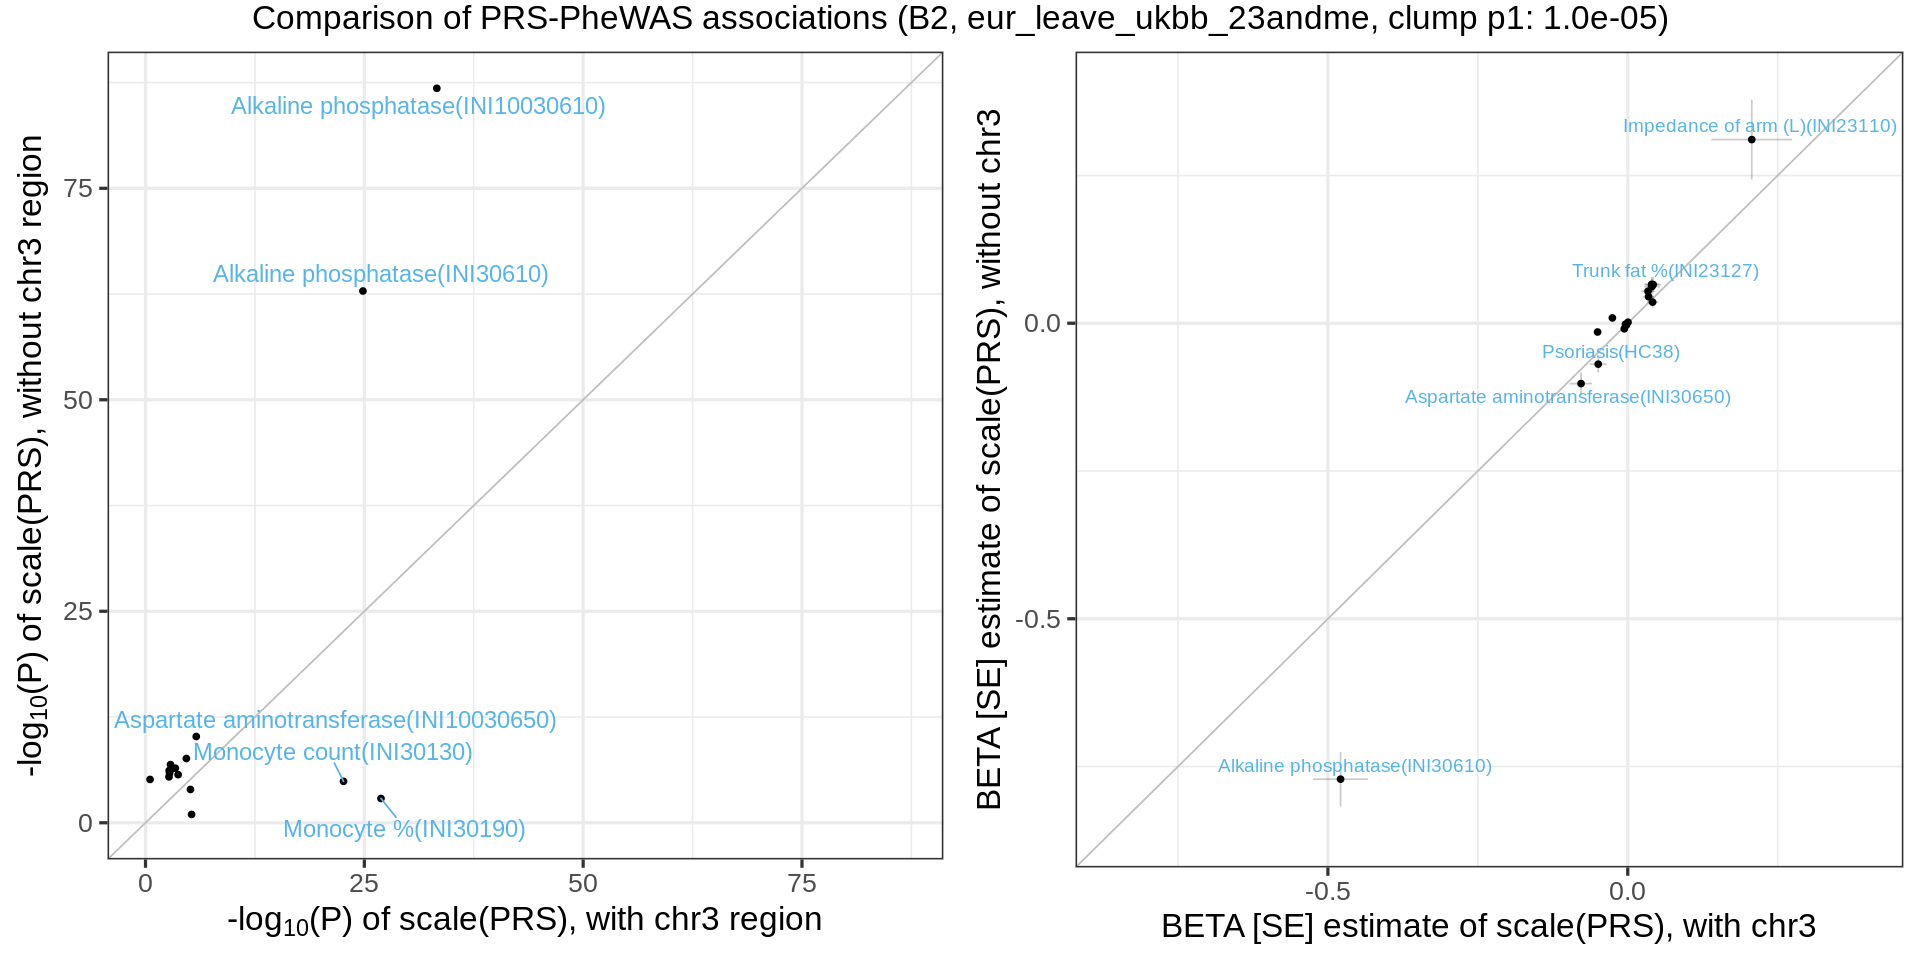

In [14]:
options(repr.plot.width=16, repr.plot.height=8)
gridExtra::grid.arrange(
    dff %>% p_pval_vs_pval(), 
    dff %>% p_beta_vs_beta(),
    ncol=2,
    top=grid::textGrob(sprintf(
        "Comparison of PRS-PheWAS associations (%s, %s, clump p1: %.1e)",
        'B2',
        'eur_leave_ukbb_23andme',
        1e-5
    ),gp=grid::gpar(fontsize=20))
)


In [10]:
dff %>% select(all_of(browse_table_colnames)) %>% arrange(`P.w_chr3`) %>% head()


GBE_category,GBE_ID,GBE_short_name,estimate.w_chr3,SE.w_chr3,P.w_chr3,estimate.wo_chr3,SE.wo_chr3,P.wo_chr3
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Biomarkers,INI10030610,Alkaline phosphatase,-0.005770931,0.0004745987,5.190101e-34,-0.009415319,0.0004745672,1.524989e-87
Blood_assays,INI30190,Monocyte %,-0.050301629,0.0046175429,1.250235e-27,-0.014813909,0.0046197886,1.343169e-03
Blood_assays,INI30610,Alkaline phosphatase,-0.478839976,0.0458122544,1.444830e-25,-0.771386563,0.0458144301,1.386976e-63
Blood_assays,INI30130,Monocyte count,-0.003785308,0.0003801780,2.376329e-23,-0.001660600,0.0003803463,1.265688e-05
Biomarkers,INI10030650,Aspartate aminotransferase,-0.002244956,0.0004678284,1.597911e-06,-0.003058345,0.0004679624,6.351331e-11
Health_and_medical_history,BIN_FC1006149,Mouth ulcers,-0.025612879,0.0056343077,5.470655e-06,0.009025870,0.0055594244,1.044770e-01


In [11]:
dff %>% select(all_of(browse_table_colnames)) %>% arrange(`P.wo_chr3`) %>% head()


GBE_category,GBE_ID,GBE_short_name,estimate.w_chr3,SE.w_chr3,P.w_chr3,estimate.wo_chr3,SE.wo_chr3,P.wo_chr3
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Biomarkers,INI10030610,Alkaline phosphatase,-0.005770931,0.0004745987,5.190101e-34,-0.009415319,0.0004745672,1.524989e-87
Blood_assays,INI30610,Alkaline phosphatase,-0.478839976,0.0458122544,1.444830e-25,-0.771386563,0.0458144301,1.386976e-63
Biomarkers,INI10030650,Aspartate aminotransferase,-0.002244956,0.0004678284,1.597911e-06,-0.003058345,0.0004679624,6.351331e-11
Blood_assays,INI30650,Aspartate aminotransferase,-0.077857015,0.0183210694,2.142234e-05,-0.102079971,0.0183264784,2.548238e-08
Anthropometry,INI23127,Trunk fat %,0.039839910,0.0124557605,1.381514e-03,0.065724796,0.0124594703,1.327758e-07
Disease_outcome,HC38,Psoriasis,-0.049233114,0.0138903525,3.934918e-04,-0.069202233,0.0135900541,3.540754e-07


In [15]:
wide_df %>%
filter(
    HGI_case_control == 'B2', 
    HGI_suffix == 'eur_leave_ukbb_23andme',
    clump_p1 == 1e-4
) -> dff


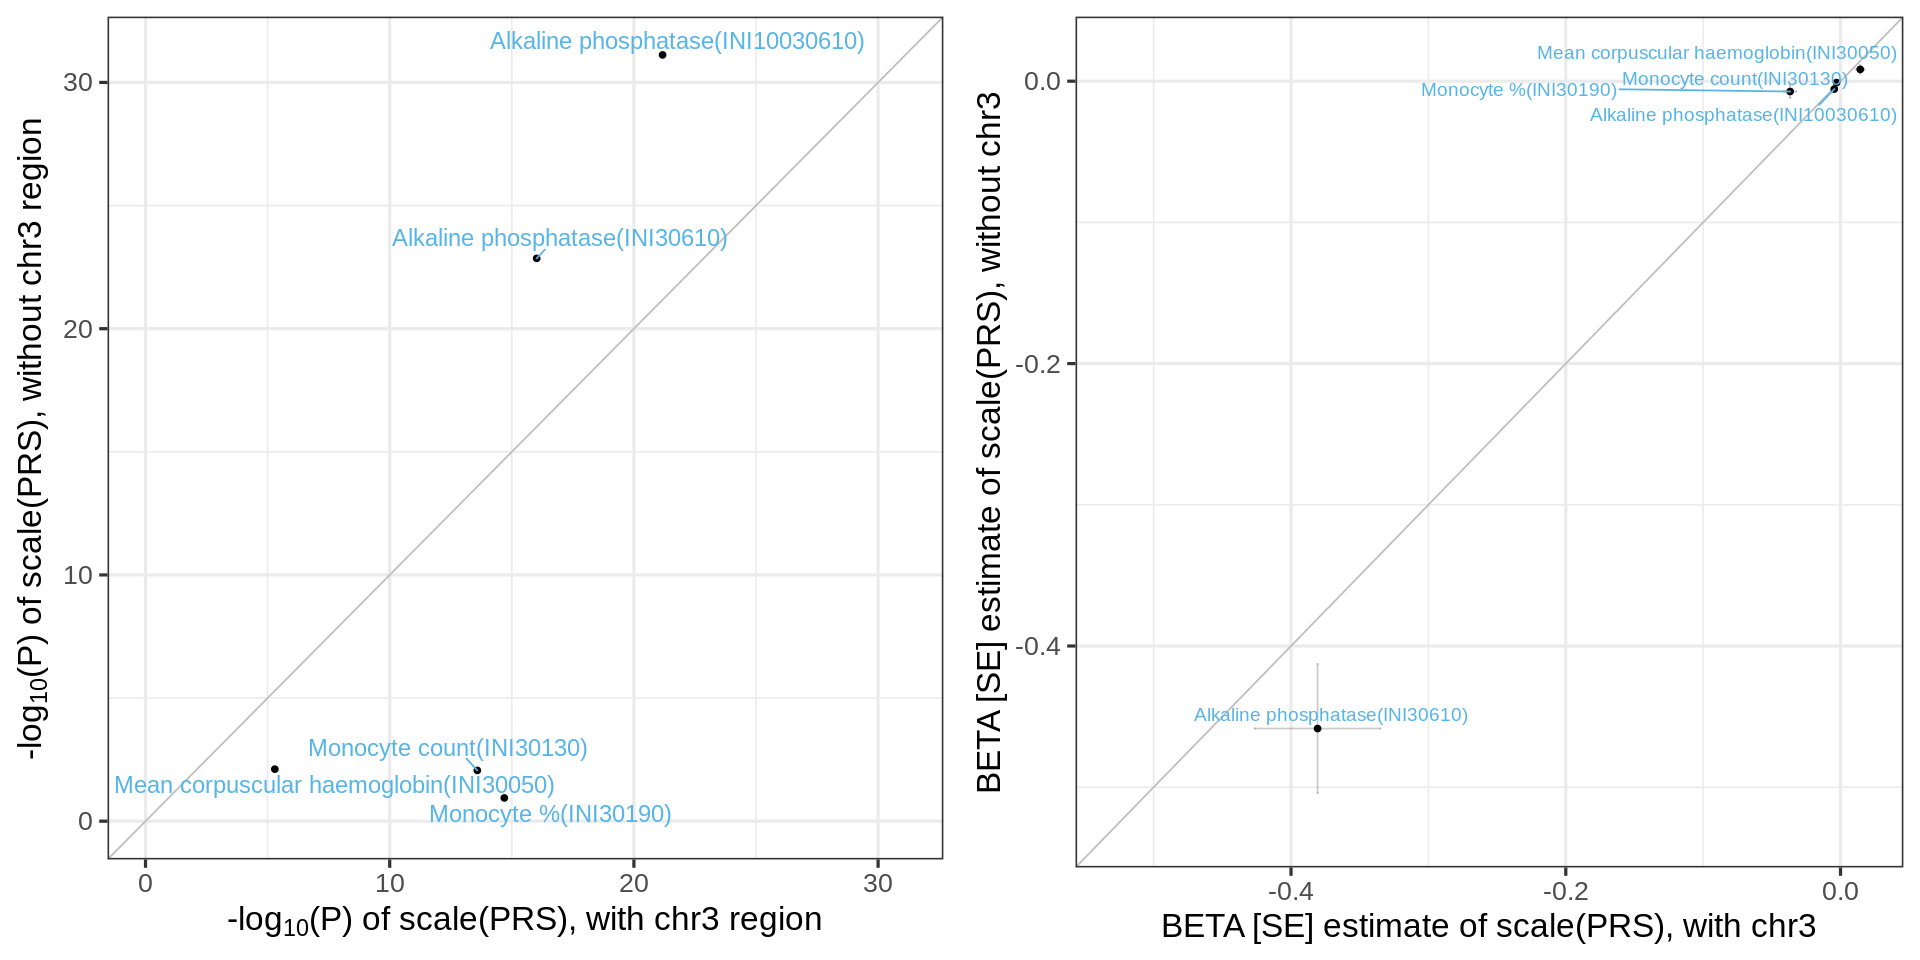

In [16]:
options(repr.plot.width=16, repr.plot.height=8)
gridExtra::grid.arrange(
    dff %>% p_pval_vs_pval(), 
    dff %>% p_beta_vs_beta(), 
    ncol=2
)


In [17]:
wide_df %>%
filter(
    HGI_case_control == 'B2', 
    HGI_suffix == 'eur_leave_ukbb_23andme',
    clump_p1 == 1e-3
) -> dff


In [18]:
dff %>% select(all_of(browse_table_colnames)) %>% arrange(-`estimate.w_chr3`) %>% head()


GBE_category,GBE_ID,GBE_short_name,estimate.w_chr3,SE.w_chr3,P.w_chr3,estimate.wo_chr3,SE.wo_chr3,P.wo_chr3
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Anthropometry,INI23100,Whole body fat mass,0.07099025,0.015946419,8.518162e-06,0.07820061,0.015946302,9.395038e-07
Anthropometry,INI23119,Arm fat % (R),0.05886418,0.012867884,4.775233e-06,0.06427744,0.012867794,5.879900e-07
Anthropometry,INI23123,Arm fat % (L),0.05807869,0.012985148,7.726306e-06,0.06305392,0.012985065,1.199079e-06
Anthropometry,INI23127,Trunk fat %,0.05737117,0.012452889,4.085600e-06,0.06289241,0.012452788,4.409612e-07
Anthropometry,INI23099,Body fat %,0.04726460,0.010898340,1.445734e-05,0.05175903,0.010898263,2.042156e-06
Anthropometry,INI23128,Trunk fat mass,0.04097799,0.008892787,4.067064e-06,0.04546683,0.008892703,3.175521e-07


In [19]:
dff %>% select(all_of(browse_table_colnames)) %>% arrange(-abs(`estimate.wo_chr3`)) %>% head()


GBE_category,GBE_ID,GBE_short_name,estimate.w_chr3,SE.w_chr3,P.w_chr3,estimate.wo_chr3,SE.wo_chr3,P.wo_chr3
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Anthropometry,INI23100,Whole body fat mass,0.07099025,0.015946419,8.518162e-06,0.07820061,0.015946302,9.395038e-07
Anthropometry,INI23119,Arm fat % (R),0.05886418,0.012867884,4.775233e-06,0.06427744,0.012867794,5.879900e-07
Anthropometry,INI23123,Arm fat % (L),0.05807869,0.012985148,7.726306e-06,0.06305392,0.012985065,1.199079e-06
Anthropometry,INI23127,Trunk fat %,0.05737117,0.012452889,4.085600e-06,0.06289241,0.012452788,4.409612e-07
Anthropometry,INI23099,Body fat %,0.04726460,0.010898340,1.445734e-05,0.05175903,0.010898263,2.042156e-06
Anthropometry,INI23128,Trunk fat mass,0.04097799,0.008892787,4.067064e-06,0.04546683,0.008892703,3.175521e-07


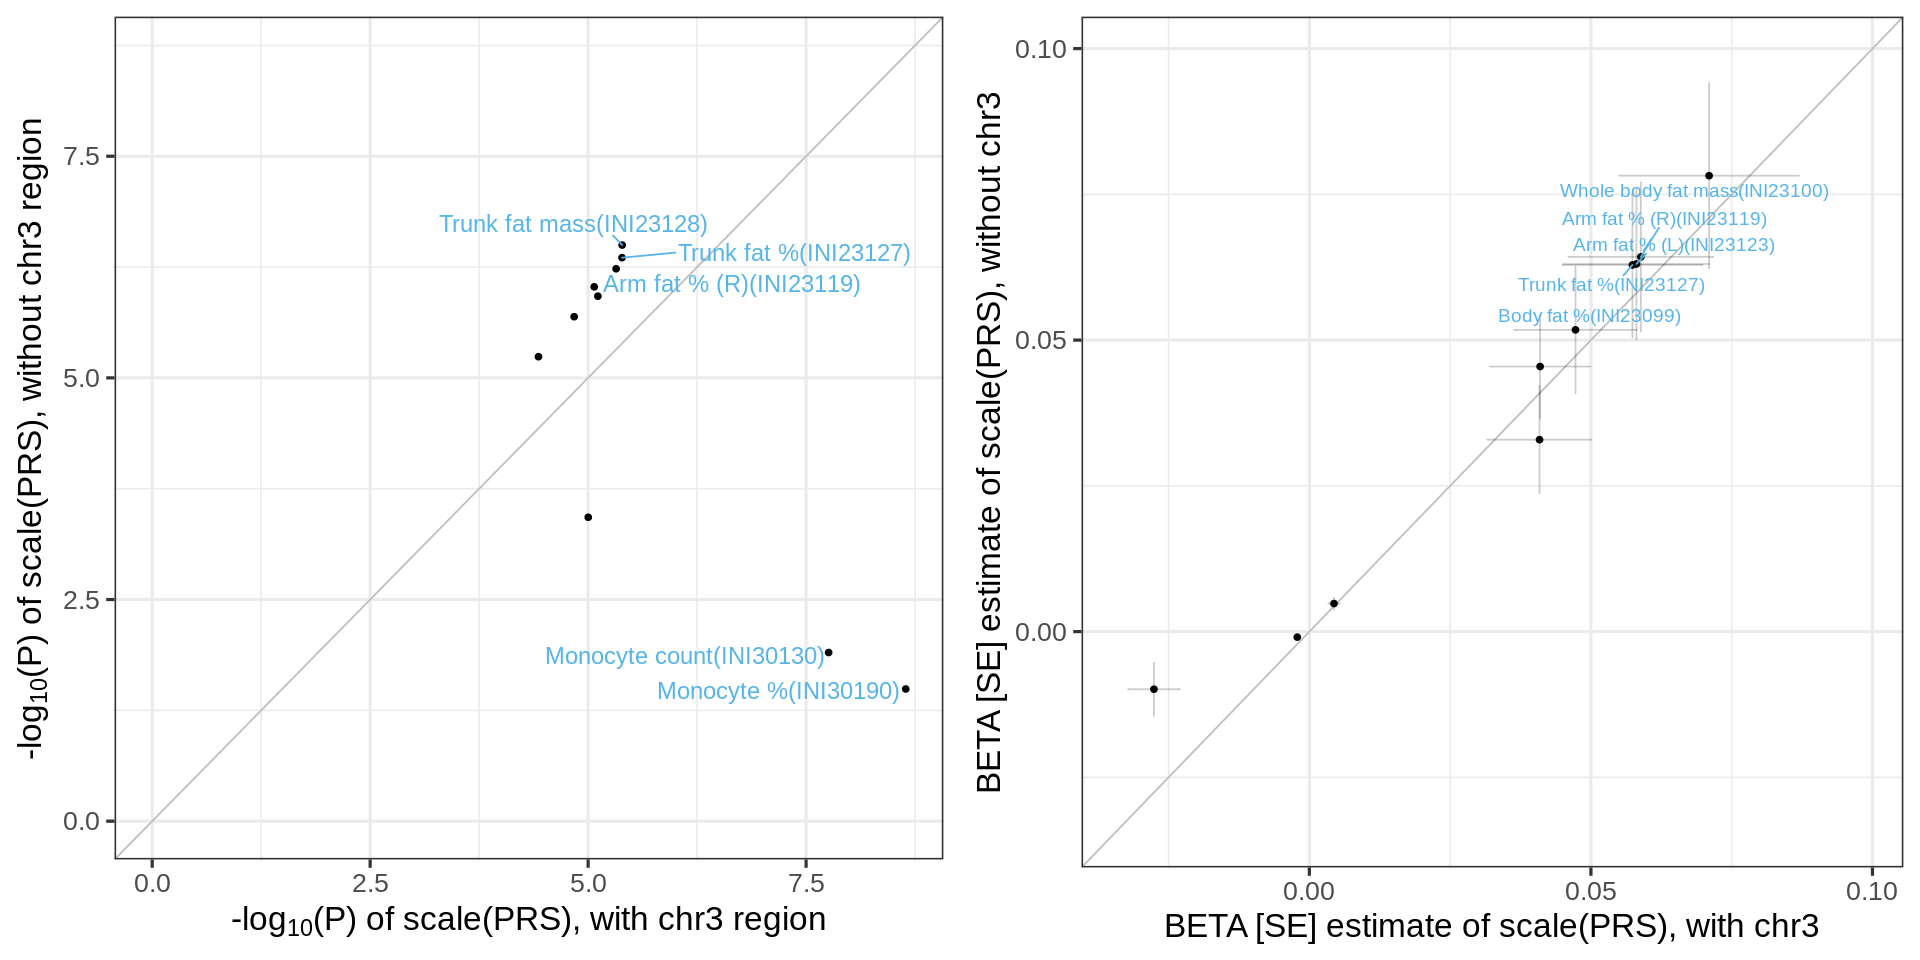

In [20]:
options(repr.plot.width=16, repr.plot.height=8)
gridExtra::grid.arrange(
    dff %>% p_pval_vs_pval(), 
    dff %>% p_beta_vs_beta(), 
    ncol=2
)


In [42]:
wide_df %>%
filter(
    HGI_case_control == 'C2', 
    HGI_suffix == 'eur_leave_ukbb_23andme',
    clump_p1 == 1e-5
) -> dff


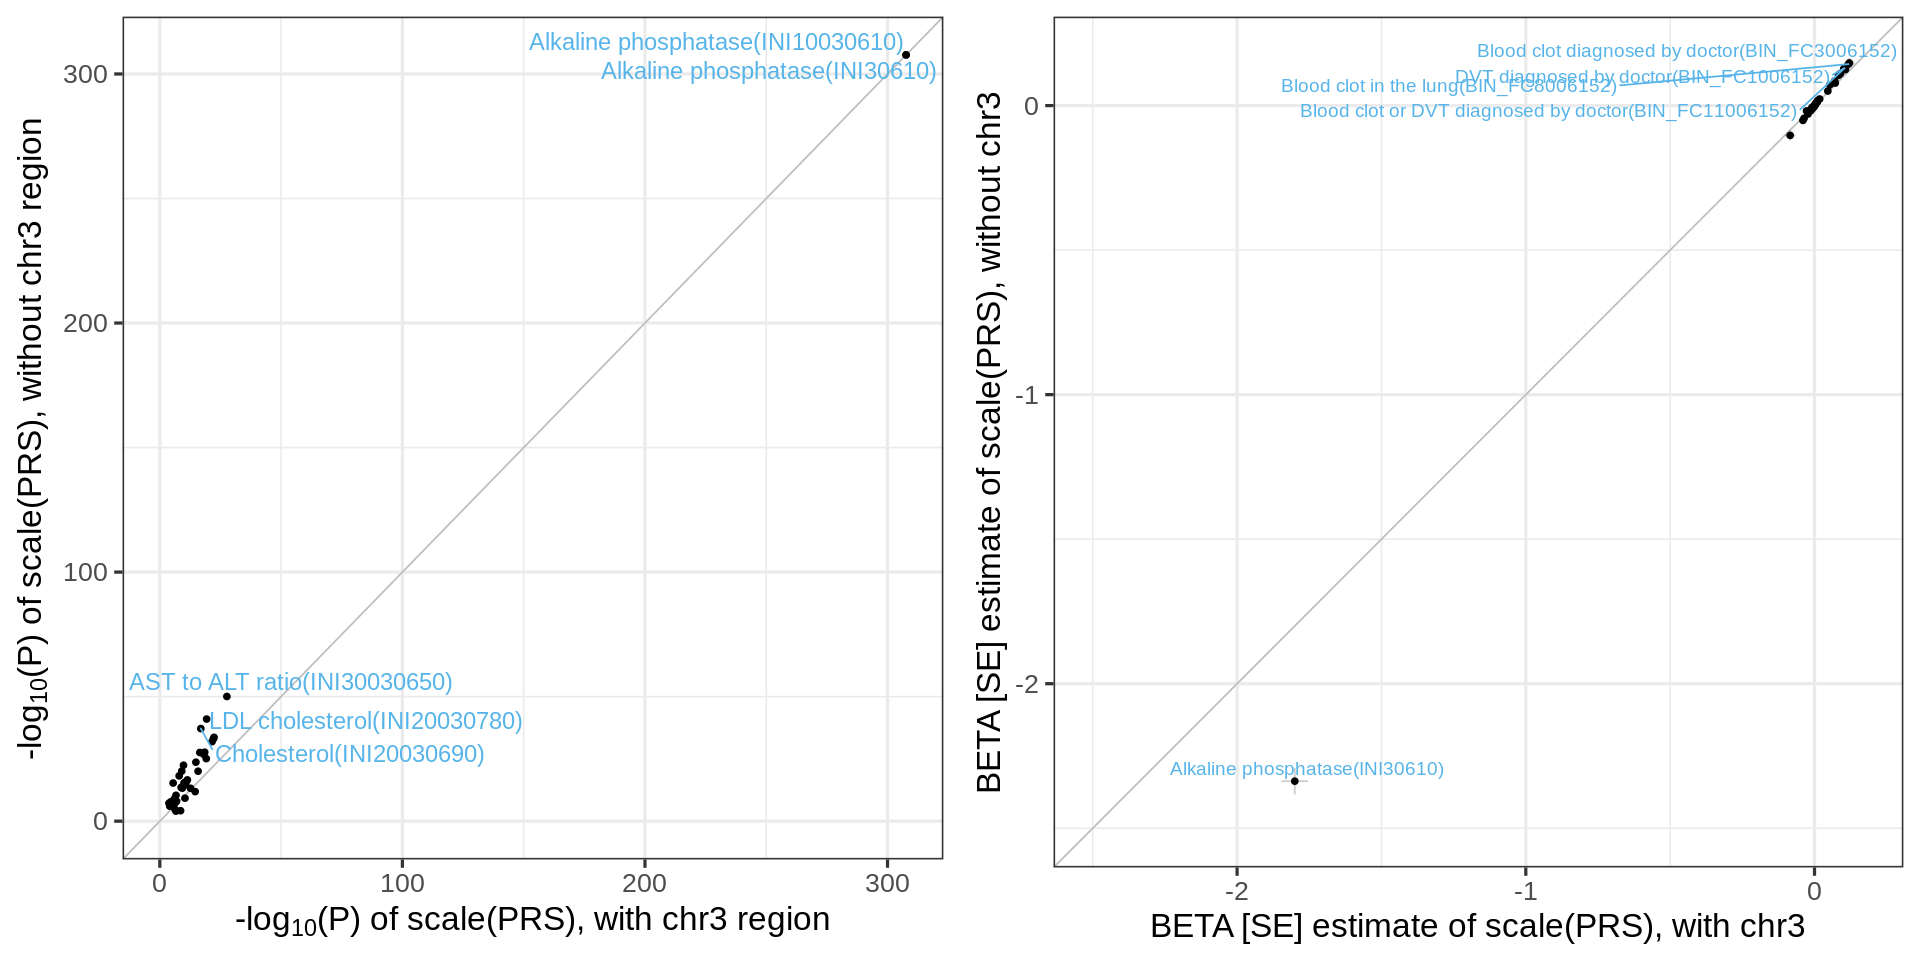

In [43]:
options(repr.plot.width=16, repr.plot.height=8)
gridExtra::grid.arrange(
    dff %>% p_pval_vs_pval(), 
    dff %>% p_beta_vs_beta(), 
    ncol=2
)
